In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import json
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
from area import area
from sklearn import neighbors
from matplotlib.pyplot import figure

%matplotlib inline

In [2]:
postmates = pd.read_csv('/Users/baileyrusso/PycharmProjects/GrubHubScraper/postmates_all7.csv')
postmates = postmates.loc[:, ~postmates.columns.str.contains('^Unnamed')]

# Categories with most favorites

In [3]:
#postmatesDroppedCat = postmates[postmates.groupby(['Category']).size() > 5]
#postmatesDroppedCat.groupby('Category').aggregate('mean').sort_values('Favorites',ascending=False).head(25)
subsetCat = postmates['Category'].unique()[postmates.groupby(['Category','Name']).size().groupby('Category').count() > 5]
postmatesDroppedCat = postmates[postmates['Category'].isin(subsetCat)]
postmatesDroppedCat = postmatesDroppedCat.groupby('Category').aggregate('mean').sort_values('Favorites',ascending=False).head(25)
postmatesDroppedCat

,Favorites,MenuItemPrice,Latitude,Longitude
Category,,,,
DIM SUM,405.306011,17.420055,40.776923,-73.966243
SHANGHAI,330.000000,17.365854,40.668645,-73.993636
SUSHI,195.249230,13.442098,40.741909,-73.977816
CHICKEN WINGS,184.787634,10.098261,40.758103,-73.976981
GLUTEN-FREE,172.411576,14.195925,40.769252,-73.980263
JUICE BAR,170.164577,9.283569,40.750425,-73.980554
ISRAELI,154.000000,10.604938,40.727550,-74.002408
FISH AND CHIPS,153.652174,7.294783,40.753786,-73.978759
GROCERY,137.739264,7.957097,40.738163,-73.985909


/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

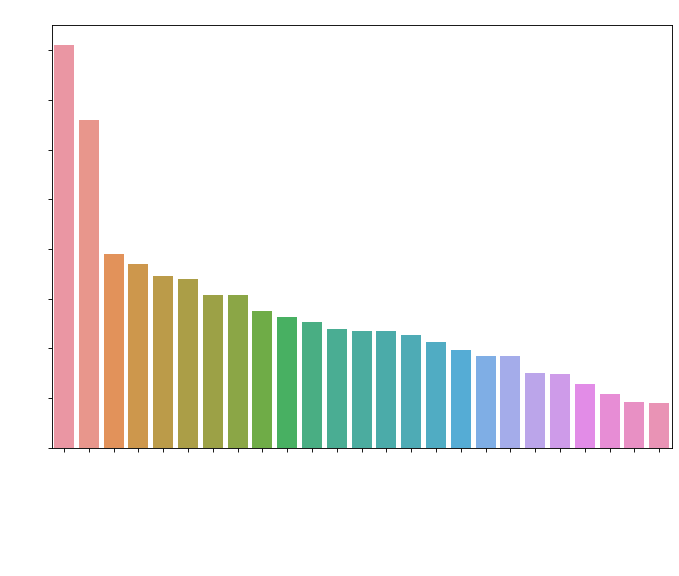

In [5]:
fig = plt.figure(figsize=(10, 7), dpi=80)

g = sns.barplot(postmatesDroppedCat.index, postmatesDroppedCat['Favorites']).set_title('Categories With Most Favorites ')


for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("white")

for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("white")
    

plt.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white"})

plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees


# Restaurants with Most Favorites

In [6]:
groupedName = postmates.groupby('Name').aggregate('mean').sort_values('Favorites',ascending=False).head(25)
groupedName

,Favorites,MenuItemPrice,Latitude,Longitude
Name,,,,
KazuNori | The Original Handroll Bar,3300.000000,14.710938,40.659813,-74.001266
SUGARFISH,1900.000000,19.974490,40.725149,-74.003624
Philippe Chow,1000.000000,30.328125,40.764192,-73.970314
Bondi Sushi - Nomad,1000.000000,8.310345,40.744668,-73.987560
The Halal Guys,961.412698,6.228525,40.762668,-73.977129
Thai Villa,928.171429,13.033333,40.738981,-73.990706
Bonchon Chicken,774.000000,10.247368,40.747406,-73.985097
Grace Street,765.000000,12.569385,40.747860,-73.986477
The Butchers Daughter,757.000000,8.900000,40.720716,-73.994785


/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

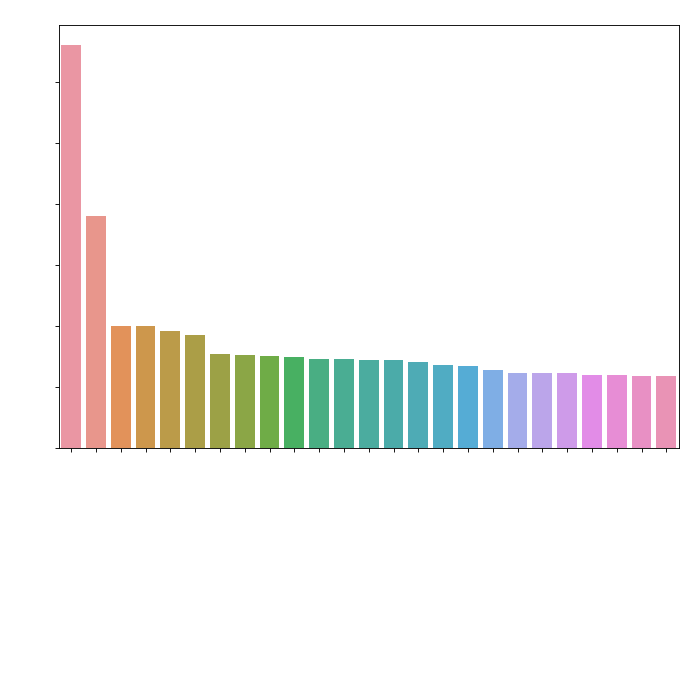

In [10]:
fig = plt.figure(figsize=(10, 7), dpi=80)

g = sns.barplot(groupedName.index, groupedName['Favorites']).set_title('Most Favorited Restaurants')

for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("white")

for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("white")
    
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

# Checking Relationship b/w Menu Item Price and Num Favorites

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


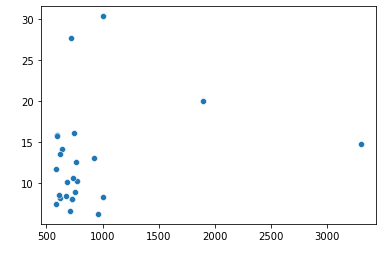

In [11]:
sns.scatterplot('Favorites','MenuItemPrice',data=groupedName,)

# Most Popular Categories

In [12]:
groupedCatCount = postmates.groupby(['Category','Name']).count().reset_index()['Category'].value_counts()
groupedCatCount

AMERICAN        60
PIZZA           45
ITALIAN         38
DELI            35
CHINESE         27
                ..
HALAL            1
ISRAELI          1
KOSHER           1
MAC & CHEESE     1
SMOOTHIES        1
Name: Category, Length: 76, dtype: int64

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

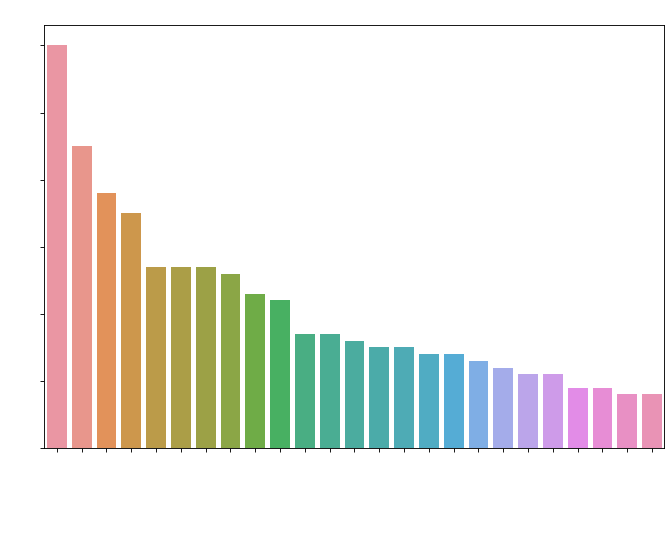

In [14]:
fig = plt.figure(figsize=(10, 7), dpi=80)
top = 25

g = sns.barplot(groupedCatCount.index[:top], groupedCatCount[:top]).set_title('Number of Categories')

for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("white")

for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("white")
    
plt.xticks(rotation = 90)

# Checking Relationship b/w Favorites and Number of Menu Items

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


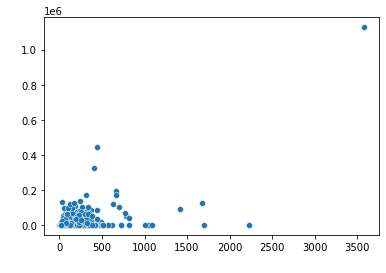

In [15]:
groupedNumItems = postmates.groupby('Name').aggregate(['count','sum'])[[('Favorites','sum'),('MenuItemPrice','count')]]#.sort_values('MenuItem',ascending=False)

sns.scatterplot(('MenuItemPrice','count'), ('Favorites','sum'), data=groupedNumItems)


In [16]:
groupedNumItems.corr()

,,Favorites,MenuItemPrice
,,sum,count
Favorites,sum,1.000000,0.606417
MenuItemPrice,count,0.606417,1.000000


# Most Popular Menu Items Sold

In [17]:
popItems = postmates['MenuItem'].value_counts().head(1000).to_frame()
popItems = popItems.reset_index()
popItems.columns = ['MenuItem','NumMenuItems']
postmatesPopItems = pd.merge(postmates, popItems, on='MenuItem').sort_values('NumMenuItems', ascending=False)

In [18]:
#postmatesPopItems.to_csv('postmatesPopItems.csv')
#postmatesPopItems['MenuItem'].unique()
[i for i in postmatesPopItems['MenuItem'].unique()]

['French Fries',
 'Onion Rings',
 'Iced Tea',
 'Soda',
 'Bottled Water',
 'Mozzarella Sticks',
 'Iced Coffee',
 'Caesar Salad',
 'Cappuccino',
 'Sweet Potato Fries',
 'Hot Chocolate',
 'Lemonade',
 'Snapple',
 'Coffee',
 'Greek Salad',
 'Espresso',
 'Diet Coke (can)',
 'Coke (can)',
 'Water (bottle)',
 'Gatorade',
 'Cheeseburger',
 'Coke',
 'Cheese Fries',
 'Tea',
 'Brown Rice',
 'Orange Juice',
 'Turkey Burger',
 'Carrot Cake',
 'Diet Coke',
 'White Rice',
 'Latte',
 'Sprite (can)',
 'Fried Calamari',
 'Veggie Burger',
 'Edamame',
 'Poland Spring Water',
 'Red Bull',
 'Hamburger',
 'Diet Coke Can',
 'Bacon Cheeseburger',
 'Home Fries',
 'Curly Fries',
 'French Toast',
 'Tiramisu',
 'Iced Latte',
 'Potato Salad',
 'Canned Soda',
 'Coleslaw',
 'Tuna Salad',
 'Egg Salad Sandwich',
 'Chicken Salad Sandwich',
 'Herbal Tea',
 'Seaweed Salad',
 'Garlic Bread',
 'Chicken Fingers',
 'Chocolate Chip Cookie',
 'Tuna Salad Sandwich',
 'Sprite',
 'Croissant',
 'Cheesecake',
 'Miso Soup',
 'Ginger 

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


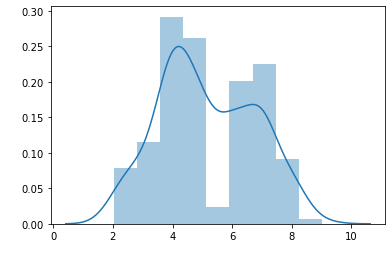

In [19]:
sns.distplot(postmatesPopItems[postmatesPopItems['MenuItem'] == 'French Fries']['MenuItemPrice'])

In [60]:
groupedMenuItems = postmatesPopItems.groupby('MenuItem').mean().sort_values(by='NumMenuItems', ascending=False)
groupedMenuItems

,Favorites,MenuItemPrice,Latitude,Longitude,NumMenuItems
MenuItem,,,,,
French Fries,84.379630,5.154319,40.750164,-73.984367,216.0
Onion Rings,66.179012,6.227532,40.745432,-73.987252,162.0
Iced Tea,69.197080,3.084275,40.746876,-73.982401,137.0
Soda,121.225000,2.370833,40.741712,-73.984003,120.0
Bottled Water,138.136752,2.362870,40.750581,-73.981540,117.0
...,...,...,...,...,...
Sushi Appetizer,86.375000,10.268750,40.733291,-73.973872,8.0
Kale Caesar Salad,94.375000,11.437500,40.757820,-73.980320,8.0
Italian Sandwich,40.500000,10.110000,40.729823,-73.989008,8.0


/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

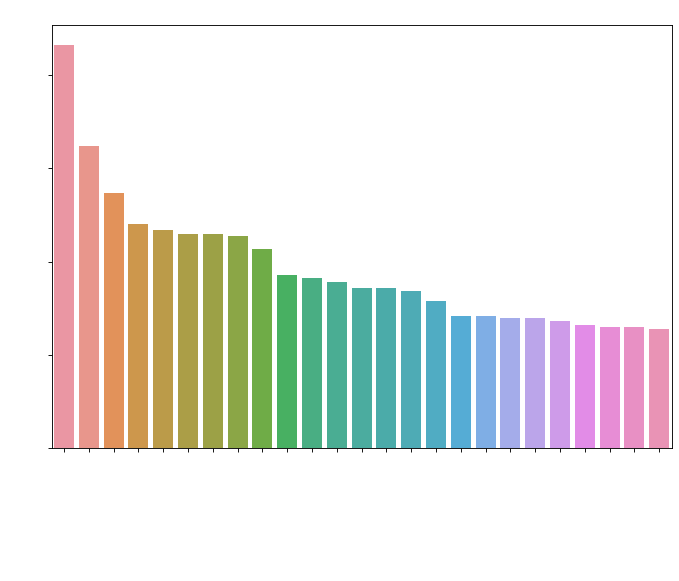

In [63]:
fig = plt.figure(figsize=(10, 7), dpi=80)
top = 25

g = sns.barplot(groupedMenuItems.index[:top], groupedMenuItems['NumMenuItems'][:top]).set_title('Most Frequent Menu Items')

for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("white")

for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("white")
    
plt.xticks(rotation = 90)

# Distrubution of Popular Menu Item Prices

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


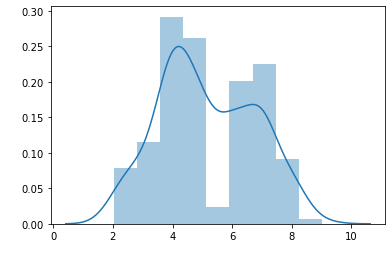

In [20]:
sns.distplot(postmates[postmates['MenuItem'] == 'French Fries']['MenuItemPrice'])

/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


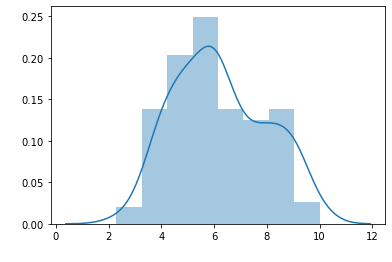

In [21]:
sns.distplot(postmates[postmates['MenuItem'] == 'Onion Rings']['MenuItemPrice'])

In [22]:
postmates[postmates['MenuItem'] == 'French Fries'].sort_values('MenuItemPrice').head(20)

,Name,Category,Favorites,Address,MenuItem,MenuItemDescription,MenuItemPrice,Address_Coordinates,Latitude,Longitude
94756,China Gourmet,CHINESE,75.0,877 8TH AVE,French Fries,NaN,2.05,"(40.7638874, -73.9851961)",40.763887,-73.985196
86386,McDonalds,FAST FOOD,86.0,1286 1ST AVE,French Fries,NaN,2.19,"(40.7659, -73.9571707)",40.765900,-73.957171
1597,Wendys,FAST FOOD,51.0,85 NASSAU STREET,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.25,"(40.710048, -74.0080338)",40.710048,-74.008034
40699,Wendys,FAST FOOD,161.0,20 E 14TH STREET,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.25,"(40.735443, -73.992632)",40.735443,-73.992632
2051,Burger King,FAST FOOD,0.0,106 FULTON ST,French Fries,NaN,2.29,"(40.709584199999995, -74.007034739265)",40.709584,-74.007035
54437,Wendys,FAST FOOD,73.0,714 3RD AVE,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.29,"(40.7526054, -73.9733371)",40.752605,-73.973337
78982,Wendys,FAST FOOD,405.0,938 EIGHTH AVENUE,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.29,"(nan,)",NaN,NaN
78928,Wendys,FAST FOOD,405.0,938 EIGHTH AVENUE,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.29,"(nan,)",NaN,NaN
40070,McDonalds,FAST FOOD,63.0,541 6TH AVE,French Fries,NaN,2.39,"(40.6646468, -73.98650185)",40.664647,-73.986502
21438,McDonalds,FAST FOOD,0.0,1528 BROADWAY,French Fries,NaN,2.49,"(40.9007547, -73.8969627)",40.900755,-73.896963


# Sorting Items By Median Menu Item Price

In [23]:
postmates.groupby('Name').median().sort_values('MenuItemPrice', ascending=False).head(60)

,Favorites,MenuItemPrice,Latitude,Longitude
Name,,,,
111 Lex Wine & Liquors,0.0,46.990,40.742352,-73.982450
Baked By Melissa,0.0,43.000,40.738394,-73.994948
Sweet Reha,0.0,38.020,40.726725,-74.001944
Sweet Rehab,0.0,36.520,40.726725,-74.001944
Sant Ambroeus 1000 Madison,583.0,32.000,40.775465,-73.963085
Nobu Fifty Seven,469.0,30.000,40.646134,-74.022767
Amaranth,0.0,29.000,40.765804,-73.970287
Mr. Chow New York,255.0,28.500,40.643320,-74.017936
NYC Wine & Spirits,0.0,28.490,40.789473,-73.975905


# Sorting Restaurants By Number of Locations

In [24]:
postmates.groupby(['Name','Address_Coordinates']).count().reset_index()['Name'].value_counts().sort_values(ascending=False).head(60)

McDonalds                           7
Subway                              6
The Ice Cream Shop                  5
Taco Bell                           5
Burger King                         5
Five Guys Burgers and Fries         4
Wendys                              4
Chipotle Mexican Grill              4
Famous Original Rays Pizza          4
Brekkie Bagels                      4
7-Eleven                            4
Krispy Kreme Doughnuts              3
The Halal Guys                      3
Mels Melts                          3
Just Wing It.                       3
Juice Generation                    3
Tacombi                             3
Killer Wings                        3
Just Salad                          3
JOE & THE JUICE                     3
Joes Pizza                          3
B*tch Dont Grill My Cheese          3
sweetgreen                          3
Cheekys Cheesesteaks                3
Pressed Juicery                     3
Shake Shack                         3
Van Leeuwen 

In [25]:
postmates.sort_values(['MenuItem','MenuItemPrice'])

,Name,Category,Favorites,Address,MenuItem,MenuItemDescription,MenuItemPrice,Address_Coordinates,Latitude,Longitude
11202,Hampton Chutney Co.,INDIAN,79.0,143 GRAND ST,"# 16 Fresh Mozzarella, Roasted peppers, arugul...",NaN,9.95,"(40.7150004, -73.96204710485655)",40.715000,-73.962047
11207,Hampton Chutney Co.,INDIAN,79.0,143 GRAND ST,"# 21 Avocado, Fresh mozzarella, cucumber, toma...",NaN,10.95,"(40.7150004, -73.96204710485655)",40.715000,-73.962047
59916,Sarges Delicatessen & Diner,AMERICAN,293.0,548 3RD AVE,#1 Assorted Salad Buffet (10 Person Minimum),"Tuna salad, chicken salad, and egg salad. Incl...",139.50,"(40.7473351, -73.9771952)",40.747335,-73.977195
3470,Kossars Bagels and Bialys,BAGEL,61.0,367 GRAND ST,#1 BAGEL PACKAGE,6 Assorted bagels with 1/2 lb. Cream Cheese,13.75,"(40.7164072, -73.9887865)",40.716407,-73.988787
11182,Hampton Chutney Co.,INDIAN,79.0,143 GRAND ST,#1 Classic Masala (Spiced Indian Potatoes),NaN,10.95,"(40.7150004, -73.96204710485655)",40.715000,-73.962047
...,...,...,...,...,...,...,...,...,...,...
94864,Lukes Lobster,SEAFOOD,234.0,426 AMSTERDAM AVE,NaN,NaN,NaN,"(40.784197, -73.9778027)",40.784197,-73.977803
96084,Cha Pas Noodles and Grill,VIETNAMESE,0.0,314 W 52ND ST,NaN,NaN,NaN,"(40.646145999999995, -74.01525242857143)",40.646146,-74.015252
96126,Lilis Bake Shop,BAKERY,0.0,828 7TH AVE,NaN,NaN,NaN,"(40.763483, -73.9817401)",40.763483,-73.981740
96296,Ladur\xc3\xa9e,FRENCH,194.0,864 MADISON AVE,NaN,NaN,NaN,"(40.770816, -73.9663389)",40.770816,-73.966339


# Prices for each Category

In [49]:
groupedCatPrice = postmates.groupby('Category').agg(['mean'])['MenuItemPrice'].sort_values(by='mean',ascending=False)
groupedCatPrice

,mean
Category,
ALCOHOL,42.121902
STEAK,26.581982
PUB,22.384259
SEAFOOD,17.513721
DIM SUM,17.420055
...,...
DELI,5.988813
TEA,5.968095
CONVENIENCE,5.894777


/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

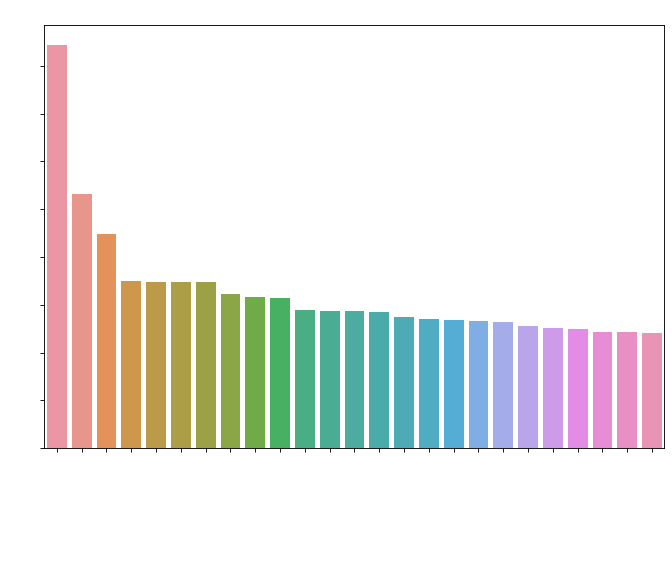

In [51]:
fig = plt.figure(figsize=(10, 7), dpi=80)
top = 25

g = sns.barplot(groupedCatPrice.index[:top], groupedCatPrice['mean'][:top]).set_title('Mean Price of Categories')

for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("white")

for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("white")
    
plt.xticks(rotation = 90)

In [47]:
groupedCatPrice = postmates.groupby('Category').agg(['mean'])['MenuItemPrice'].sort_values(by='mean',ascending=True)
groupedCatPrice

,mean
Category,
SOUTHERN,4.274938
BOBA,5.534342
CONVENIENCE,5.894777
TEA,5.968095
DELI,5.988813
...,...
DIM SUM,17.420055
SEAFOOD,17.513721
PUB,22.384259


/Users/baileyrusso/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

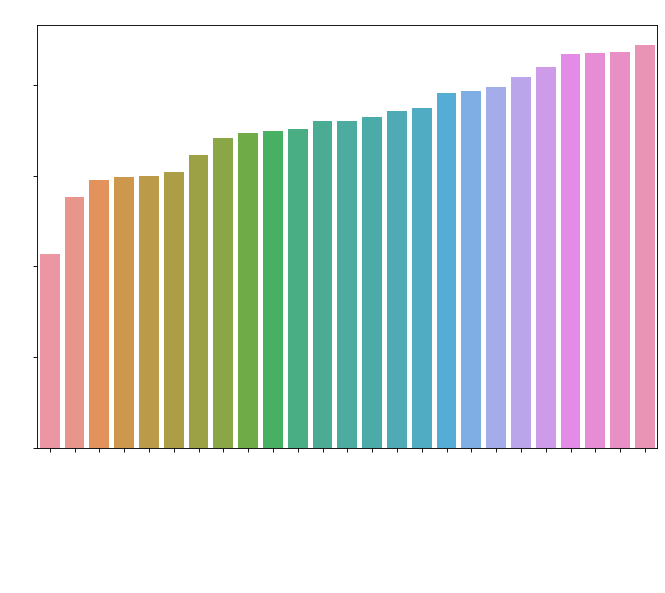

In [48]:
fig = plt.figure(figsize=(10, 7), dpi=80)
top = 25

g = sns.barplot(groupedCatPrice.index[:top], groupedCatPrice['mean'][:top]).set_title('Mean Price of Categories')

for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("white")

for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("white")
    
plt.xticks(rotation = 90)

# Getting price distribution for each restaurant

In [65]:
catCount = []
for key, value in postmates.groupby('Name'):
    print(value.head())

                  Name Category  Favorites       Address         MenuItem  \
36779  #1 Gourmet Deli     DELI        0.0  51 E 34TH ST     French Fries   
36780  #1 Gourmet Deli     DELI        0.0  51 E 34TH ST      Curly Fries   
36781  #1 Gourmet Deli     DELI        0.0  51 E 34TH ST  Chicken Tenders   
36782  #1 Gourmet Deli     DELI        0.0  51 E 34TH ST    Chicken Wings   
36783  #1 Gourmet Deli     DELI        0.0  51 E 34TH ST      Onion Rings   

      MenuItemDescription  MenuItemPrice  \
36779                 NaN           3.99   
36780                 NaN           3.99   
36781           5 pieces.           5.99   
36782           5 pieces.           5.99   
36783                 NaN           3.99   

                           Address_Coordinates   Latitude  Longitude  
36779  (40.65755325862069, -74.00658922413793)  40.657553 -74.006589  
36780  (40.65755325862069, -74.00658922413793)  40.657553 -74.006589  
36781  (40.65755325862069, -74.00658922413793)  40.657553 -

94094  (40.7628613, -73.985265)  40.762861 -73.985265  
            Name Category  Favorites            Address         MenuItem  \
79274  Big Italy  ITALIAN        0.0  502 AMSTERDAM AVE    Caprese Salad   
79275  Big Italy  ITALIAN        0.0  502 AMSTERDAM AVE        Meatballs   
79276  Big Italy  ITALIAN        0.0  502 AMSTERDAM AVE   Fried Calamari   
79277  Big Italy  ITALIAN        0.0  502 AMSTERDAM AVE  Chicken Marsala   
79278  Big Italy  ITALIAN        0.0  502 AMSTERDAM AVE  Chicken Piccata   

                                     MenuItemDescription  MenuItemPrice  \
79274  Fresh mozzarella, tomatoes, and basil with bal...           18.0   
79275  Four juicy meatballs in our house marinara sauce.           15.0   
79276  Crispy fried marinara served with a marinara d...           17.0   
79277  Chicken breast dressed with a sauce of mushroo...           28.0   
79278  Chicken breast in a delicious piccata sauce of...           28.0   

                   Address_Coordinat

4049            5.3  (40.709902, -74.0068431)  40.709902 -74.006843  
                   Name  Category  Favorites      Address       MenuItem  \
62100  Chirping Chicken  AMERICAN       88.0  350 3RD AVE  Italian Salad   
62101  Chirping Chicken  AMERICAN       88.0  350 3RD AVE    Greek Salad   
62102  Chirping Chicken  AMERICAN       88.0  350 3RD AVE    Green Salad   
62103  Chirping Chicken  AMERICAN       88.0  350 3RD AVE   Caesar Salad   
62104  Chirping Chicken  AMERICAN       88.0  350 3RD AVE  Arugula Salad   

      MenuItemDescription  MenuItemPrice                Address_Coordinates  \
62100                 NaN           11.0  (40.74067795, -73.98216096160549)   
62101                 NaN           11.0  (40.74067795, -73.98216096160549)   
62102                 NaN           10.0  (40.74067795, -73.98216096160549)   
62103                 NaN           10.0  (40.74067795, -73.98216096160549)   
62104                 NaN           10.0  (40.74067795, -73.98216096160549)   

15132  (40.7215851, -73.9972327)  40.721585 -73.997233  
                      Name Category  Favorites      Address  \
30814  El Burrito Borracho  MEXICAN        0.0  939 1ST AVE   
30815  El Burrito Borracho  MEXICAN        0.0  939 1ST AVE   
30816  El Burrito Borracho  MEXICAN        0.0  939 1ST AVE   
30817  El Burrito Borracho  MEXICAN        0.0  939 1ST AVE   
30818  El Burrito Borracho  MEXICAN        0.0  939 1ST AVE   

                           MenuItem  \
30814        White Burrito Burracho   
30815        Super Burrito Burracho   
30816                         Chips   
30817  Guac n Roll Burrito Burracho   
30818               Meat Quesadilla   

                                     MenuItemDescription  MenuItemPrice  \
30814  Burrito with your choice of meat, rice, beans,...          11.99   
30815  Burrito with your choice of meat, rice, beans,...          11.99   
30816                                                NaN           2.99   
30817  Burrito with your choi

49117 -73.989312  
                  Name Category  Favorites      Address         MenuItem  \
45552  Hollywood Diner    DINER      239.0  574 6TH AVE         Two Eggs   
45553  Hollywood Diner    DINER      239.0  574 6TH AVE      Iced Coffee   
45554  Hollywood Diner    DINER      239.0  574 6TH AVE  Chicken Fingers   
45555  Hollywood Diner    DINER      239.0  574 6TH AVE      Beef Burger   
45556  Hollywood Diner    DINER      239.0  574 6TH AVE             Soda   

                         MenuItemDescription  MenuItemPrice  \
45552  Served with choice of side and toast.           8.25   
45553                                    NaN           3.45   
45554                                    NaN          12.00   
45555                                    NaN          10.95   
45556                                    NaN           3.45   

             Address_Coordinates   Latitude  Longitude  
45552  (40.7387219, -73.9956236)  40.738722 -73.995624  
45553  (40.7387219, -73.9956236

9158  (40.7347076, -73.992346)  40.734708 -73.992346  
                     Name Category  Favorites      Address  \
64579  Librettos Pizzeria    PIZZA       54.0  546 3RD AVE   
64580  Librettos Pizzeria    PIZZA       54.0  546 3RD AVE   
64581  Librettos Pizzeria    PIZZA       54.0  546 3RD AVE   
64582  Librettos Pizzeria    PIZZA       54.0  546 3RD AVE   
64583  Librettos Pizzeria    PIZZA       54.0  546 3RD AVE   

                     MenuItem  \
64579            Garlic Knots   
64580     Rigatoni Alla Vodka   
64581   Large Cheese Pizza 18   
64582                    Coke   
64583  Medium Cheese Pizza 14   

                                     MenuItemDescription  MenuItemPrice  \
64579                    4 piece. side of marinara sauce           2.95   
64580  Light vodka and tomato sauce and a touch of he...          14.95   
64581  Classic cheese or create your own pizza. Avail...          19.95   
64582                                                NaN           1.75  

51304  (40.6716258, -73.97464246890513)  40.671626 -73.974642  
                  Name Category  Favorites       Address  \
40265  NY Street Pizza    PIZZA        0.0  69 7TH AVE S   
40266  NY Street Pizza    PIZZA        0.0  69 7TH AVE S   
40267  NY Street Pizza    PIZZA        0.0  69 7TH AVE S   
40268  NY Street Pizza    PIZZA        0.0  69 7TH AVE S   
40269  NY Street Pizza    PIZZA        0.0  69 7TH AVE S   

                           MenuItem  \
40265             Mozzarella Sticks   
40266                  Garlic Bread   
40267  Eggplant with Ricotta Cheese   
40268                       Burrata   
40269                  Caesar Salad   

                                 MenuItemDescription  MenuItemPrice  \
40265                8 pcs crispy mozzarella sticks.          13.99   
40266                                            NaN           5.99   
40267  Fresh and tasty eggplant with ricotta cheese.          15.99   
40268       Served with cherry tomatoes and arugula.    

1957  (40.7179194, -74.00059310952028)  40.717919 -74.000593  
                        Name  Category  Favorites            Address  \
3945  Potbelly Sandwich Shop  SANDWICH        0.0  127 FULTON STREET   
3946  Potbelly Sandwich Shop  SANDWICH        0.0  127 FULTON STREET   
3947  Potbelly Sandwich Shop  SANDWICH        0.0  127 FULTON STREET   
3948  Potbelly Sandwich Shop  SANDWICH        0.0  127 FULTON STREET   
3949  Potbelly Sandwich Shop  SANDWICH        0.0  127 FULTON STREET   

                   MenuItem  \
3945        Grilled Chicken   
3946       Broccoli Cheddar   
3947  Mediterranean Chicken   
3948          Turkey Breast   
3949                Italian   

                                    MenuItemDescription  MenuItemPrice  \
3945  All-natural chicken breast hand-sliced with me...            NaN   
3946  Creamy cheese soup with tender pieces of brocc...            NaN   
3947  All-natural chicken breast with zippy hummus a...            NaN   
3948  Hand-sliced tur

75057  (40.76196955, -73.96059209999999)  40.76197 -73.960592  
             Name Category  Favorites          Address  \
50171  Sweet Reha  DESSERT        0.0  135 SULLIVAN ST   
50172  Sweet Reha  DESSERT        0.0  135 SULLIVAN ST   
50173  Sweet Reha  DESSERT        0.0  135 SULLIVAN ST   
50174  Sweet Reha  DESSERT        0.0  135 SULLIVAN ST   
50175  Sweet Reha  DESSERT        0.0  135 SULLIVAN ST   

                                  MenuItem  \
50171       Sweet Rehab Classic Cookie (5)   
50172                    Lemon & Yuzu Tart   
50173  Super Dark Crunchy Chocolate Mousse   
50174                 Raspberry Honey Tart   
50175                  Chocolate Explosion   

                                     MenuItemDescription  MenuItemPrice  \
50171  Dark & milk chocolate chip cookie with coconut...          21.52   
50172  Crunchy almond dough, lemon & yuzu cream, lemo...          14.52   
50173  70% dark chocolate mousse, crunchy mix of nuts...          21.52   
50174  Cru

80453  (40.7846269, -73.9732863)  40.784627 -73.973286  
                     Name  Category  Favorites      Address  \
29595  Tonic Times Square  AMERICAN        0.0  727 7TH AVE   
29596  Tonic Times Square  AMERICAN        0.0  727 7TH AVE   
29597  Tonic Times Square  AMERICAN        0.0  727 7TH AVE   
29598  Tonic Times Square  AMERICAN        0.0  727 7TH AVE   
29599  Tonic Times Square  AMERICAN        0.0  727 7TH AVE   

                     MenuItem                  MenuItemDescription  \
29595                   Wings       Carrot and blue cheese. Spicy.   
29596  Buffalo Chicken Strips  Carrot & blue cheese. Served spicy.   
29597     Buffalo Cauliflower  Carrot & blue cheese. Served spicy.   
29598                 Edamame   Sea salt. Vegan & gluten-friendly.   
29599          Fried Calamari                      Marinara sauce.   

       MenuItemPrice               Address_Coordinates   Latitude  Longitude  
29595           14.0  (40.7599886, -73.98365629999999)  40.75998

In [109]:
postmates_reshaped = postmates.set_index(
    [postmates.groupby('Name').cumcount(), 'Name']
)['MenuItemPrice'].unstack()

In [104]:
postmates_reshaped

Name,#1 Gourmet Deli,111 Lex Wine & Liquors,16 Handles,16 Handles Frozen Yogurt and Ice Cream,16 Handles TurnStyle,5 Brothers Gourmet Market,7 Brothers Deli,7-Eleven,8th Ave Gourmet Deli,9th Ave. Gourmet Deli,...,Yi Fang Taiwan Fruit Tea,Yo Sushi,Yours Wholesome Foods,ZLS BBQ INC \xe4\xb8\xad\xe8\xa1\x97\xe5\xa4\xa7\xe4\xb8\xb2,Zen Pot,bb.q Olive Chicken,by CHLOE.,iPizza NY,sweetgreen,Épicerie Boulud
0,3.99,32.99,6.95,7.95,6.85,3.99,5.99,3.50,1.75,7.95,...,7.25,6.75,NaN,3.50,NaN,12.89,12.95,8.95,10.75,12.0
1,3.99,34.99,6.95,7.95,6.85,3.99,2.75,4.69,2.25,7.95,...,6.25,6.25,NaN,3.50,15.95,10.99,12.95,15.99,16.15,8.5
2,5.99,31.99,6.95,7.95,6.85,8.95,5.99,4.69,5.99,6.50,...,6.00,2.00,14.99,3.50,14.95,10.99,10.00,5.00,10.75,7.0
3,5.99,17.99,6.95,7.95,6.85,8.95,4.99,4.69,3.75,3.99,...,5.00,5.25,NaN,3.95,8.95,1.75,10.00,4.99,16.15,4.0
4,3.99,29.99,6.95,7.95,6.85,8.95,6.99,3.15,2.25,8.50,...,5.00,8.00,NaN,8.00,12.95,1.50,11.95,12.99,14.35,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
#postmates_reshaped.to_csv('postmates_reshaped.csv')

In [205]:
fig = px.histogram(postmates_reshaped, x=['Yo Sushi'], nbins=20)
fig.show()